Analytic solutions of viscoelastic fluids
======

This notebook outlines and solves for an analytic solution of a viscoelastic material undergoing simple shear. 

**Simple shear in two dimensions**

This model compares the analytic to numeric stored stress of a viscoelastic material undergoing simple shear in two dimensions, as outlined in [Farrington et al (2014)](http://onlinelibrary.wiley.com/doi/10.1002/2014GC005507/abstract). The vertical velocity boundary conditions are periodic, the bottom velocity bc is no-slip with a horizontal shear velocity bc applied to the top wall until $t = 8\alpha$.


In [1]:
import UWGeodynamics as GEO

loaded rc file /Users/rfarrington/Underworld/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

# Analysis

In [3]:
eta     = 1e22 * u.pascal * u.second # Viscosity
mu      = 10e9 * u.pascal # Shear Modulus

alpha = eta / mu         # Relaxation time
dt_e    = 20e3 * u.year  # observation time
eta_eff = ( eta * dt_e ) / (alpha + dt_e)  # effective viscosity

density = 2700 * u.kilogram / u.metre**3
gravity = 9.81 * u.metre / u.second**2

shearVelocity = 0.5 * u.centimetre / u.year

print 'Relaxation time = ', alpha.to(u.years)

Relaxation time =  31688.7646408 year


# Scaling

In [4]:
model_height = 100. * u.kilometer
bodyforce = density * gravity

KL = model_height 
Kt = alpha
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [5]:
Model = GEO.Model(elementRes=(16, 16),
                  minCoord=(0., 0.),
                  maxCoord=(model_height, model_height),
                  periodic=[True, False])

In [6]:
Model.outputDir="ViscoElastoPlasticShear"

## Materials

In [7]:
viscoelastic = Model.add_material(name="Visco Elastic", shape=GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom))
viscoelasticBar = Model.add_material(name="Visco Elastic Bar", shape=GEO.shapes.Box(minX=40. * u.kilometer,
                                                                                    maxX=60. * u.kilometer,
                                                                                    top=Model.top,
                                                                                    bottom=Model.bottom))


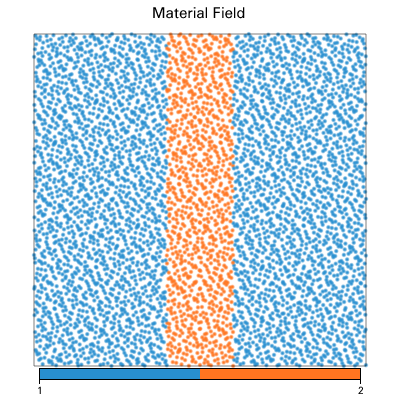

In [8]:
Fig = Model.plot.material(figsize=(400,400), fn_size=5.)

### Densities

In [9]:
viscoelastic.density = density
viscoelasticBar.density = density

### Viscosities

In [10]:
viscoelastic.viscosity = eta
viscoelasticBar.viscosity = eta

### Elasticity

In [11]:
viscoelastic.elasticity = GEO.Elasticity(shear_modulus= mu,
                                         observation_time= dt_e)
viscoelasticBar.elasticity = GEO.Elasticity(shear_modulus= mu,
                                         observation_time= dt_e)

## Velocity Boundary conditions

In [12]:
Model.set_velocityBCs(top=[shearVelocity, 0], bottom=[0, 0])

In [13]:
GEO.rcParams["solver"] = "lu"

In [14]:
tTracer      = [GEO.nd(Model.time)]
previousStress_xy  = [0.]
totalStress_xy  = [0.]

def postSolveHook():
    global tTracer, previousStress_xy, totalStress_xy
    tTracer.append(GEO.nd(Model.time))
    previousStress_xy.append(
        Model._previousStressField[2].evaluate(Model.swarm)[0])
    totalStress_xy.append(        
        Model._stressFn[2].evaluate(Model.swarm)[0])


In [15]:
Model.postSolveHook = postSolveHook

In [16]:
maxTime = 8 * alpha

In [17]:
Model.run_for(maxTime)

Time:  2.10379506498e+11 second dt: 2.10379506498e+11 second
Time:  4.20759012996e+11 second dt: 2.10379506498e+11 second
Time:  6.31138519494e+11 second dt: 2.10379506498e+11 second
Time:  8.41518025992e+11 second dt: 2.10379506498e+11 second
Time:  1.05189753249e+12 second dt: 2.10379506498e+11 second
Time:  1.26227703899e+12 second dt: 2.10379506498e+11 second
Time:  1.47265654549e+12 second dt: 2.10379506498e+11 second
Time:  1.68303605198e+12 second dt: 2.10379506498e+11 second
Time:  1.89341555848e+12 second dt: 2.10379506498e+11 second
Time:  2.10379506498e+12 second dt: 2.10379506498e+11 second
Time:  2.31417457148e+12 second dt: 2.10379506498e+11 second
Time:  2.52455407798e+12 second dt: 2.10379506498e+11 second
Time:  2.73493358447e+12 second dt: 2.10379506498e+11 second
Time:  2.94531309097e+12 second dt: 2.10379506498e+11 second
Time:  3.15569259747e+12 second dt: 2.10379506498e+11 second
Time:  3.36607210397e+12 second dt: 2.10379506498e+11 second
Time:  3.57645161047e+12

1

In [19]:
import numpy as np

# analytic soln of elastic shear stress component
V  = 0.5 * u.centimetre / u.year
h  = 100. * u.kilometer
eta = 1e22 * u.pascal * u.second
mu = 10. * u.gigapascal
C1 = -V*V*eta*eta*mu/(mu*mu*h*h + V*V*eta*eta);
C2 = -V*h*eta*mu *mu/(mu*mu*h*h + V*V*eta*eta);

increment =  301 #int(10 / (dt_e / 3.0) )
t = np.linspace(0, maxTime.to(u.year), increment)
t *= u.years

analyticSoln = np.exp(-mu/eta*t)*(C2*np.cos(V*t/h)-C1*np.sin(V*t/h))-C2

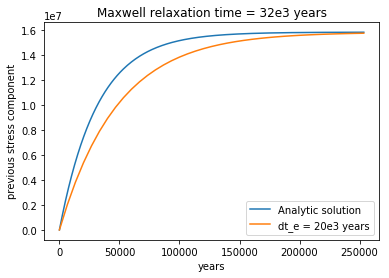

In [21]:
import pylab as plt
plt.plot(t.to(u.years), analyticSoln.to(u.pascal), label='Analytic solution')
plt.plot(GEO.Dimensionalize(tTracer, u.years), GEO.Dimensionalize(previousStress_xy, u.pascal), label='dt_e = 20e3 years')
plt.xlabel('years')
plt.ylabel('previous stress component')
plt.title('Maxwell relaxation time = 32e3 years')
plt.legend(loc='best')

plt.show()

**Numerical results compared to analytic solution**

The analytic solution shown above solves for the loading of the elastic stored stress component within a two dimensional viscoelastic material undergoing simple shear.  With an Maxwell relaxation time of $\alpha$ and an observation time of $0.6\alpha$, the numerical model recovers the majority of the elastic stress.  Reducing the observation time further results in an even smaller difference from the numerical to analytic solutions. 

Increasing the observation time results in an increased viscous portion of the total stress, resulting in increased dissipative stress during the loading phase of the model, and a corresponding decrease in stored stress to be released during the unloading phase.